# Load model

In [1]:
from keras.applications import VGG16
 
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

print(conv_base.summary())
print("Final feature map shape: 4x4")

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____________________________________________

# Feature extraction

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
 
base_dir = './cats_and_dogs'
 
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
 
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

print('test')

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print(i)
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

print("Done")

test
Found 2000 images belonging to 2 classes.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Found 1000 images belonging to 2 classes.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Found 1000 images belonging to 2 classes.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Done


# Train and fit model

In [21]:
from keras import models
from keras import layers
from keras import optimizers

test = train_features

train_features = train_features.reshape(len(train_features), 8192)
validation_features = validation_features.reshape(len(validation_features), 8192)
test_features = test_features.reshape(len(test_features), 8192)

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

network = models.Sequential()
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(1, activation='sigmoid'))
network.build((None, 8192))

network.compile(optimizer=optimizers.RMSprop(learning_rate=0.00002), loss='binary_crossentropy', metrics=['accuracy'])
print(network.summary())

history = network.fit(train_features, train_labels, batch_size=20, epochs=30, validation_data=(validation_features, validation_labels))

(2000, 8192)
(1000, 8192)
(1000, 8192)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
None
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 582us/step - loss: 0.6361 - accuracy: 0.6350 - val_loss: 0.4545 - val_accuracy: 0.8220
Epoch 2/30
2000/2000 [==============================] - 1s 494us/step - loss: 0.4364 - accuracy: 0.8050 - val_loss: 0.3772 - val_accura

# Plot the data 

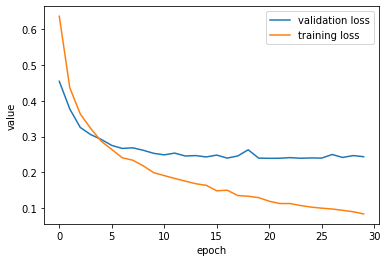

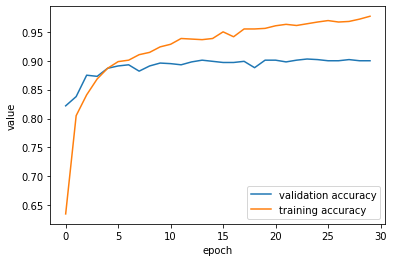

In [22]:
#%%

%matplotlib inline 
from matplotlib import pyplot as plt

history_dict = history.history
metrics = history_dict.keys()

validation_loss = history_dict['val_loss']
training_loss = history_dict['loss']

plt.plot(range(len(validation_loss)), validation_loss, label='validation loss')
plt.plot(range(len(training_loss)), training_loss, label='training loss')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

validation_acc = history_dict['val_accuracy']
training_acc = history_dict['accuracy']
plt.plot(range(len(validation_acc)), validation_acc, label='validation accuracy')
plt.plot(range(len(training_acc)), training_acc, label='training accuracy')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

# Feature extraction with extended layer

In [34]:
from keras import models
from keras import layers
 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
 
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))



Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
This is the number of trainable weights before freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4


In [45]:
from keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
 
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
 
#history = model.fit_generator(
#      train_generator,
#      steps_per_epoch=100,
#      epochs=30,
#      validation_data=validation_generator,
#      validation_steps=50,
#      verbose=2)
 

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Load pretrained model

In [38]:
import urllib.request

print('Downloading file...')

url = 'https://github.com/vakarpus/UWCC-ML410-Spring2018/raw/master/cats_and_dogs_small_3.h5'
location = './cats_and_dogs_small_3.h5'
#urllib.request.urlretrieve(url, location)
new_model = keras.models.load_model(location)
print(new_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
None


I'am not plotting results since I was unable to run the training on this model due to the resource limitations.

# Fine tuning

In [39]:
print(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [50]:
conv_base.trainable = True
 
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print('Downloading file...')

url = 'https://github.com/vakarpus/UWCC-ML410-Spring2018/raw/master/cats_and_dogs_small_4.h5'
location = './cats_and_dogs_small_4.h5'
#urllib.request.urlretrieve(url, location)
new_model2 = keras.models.load_model(location)
print(new_model2.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________
None


In [49]:
new_model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
 
#history = model.fit_generator(
#      train_generator,
#      steps_per_epoch=100,
#      epochs=100,
#      validation_data=validation_generator,
#      validation_steps=50)

# Plot data

In [ ]:
#%%

%matplotlib inline 
from matplotlib import pyplot as plt

# history_dict = history.history
metrics = history_dict.keys()

validation_loss = history_dict['val_loss']
training_loss = history_dict['loss']

plt.plot(range(len(validation_loss)), validation_loss, label='validation loss')
plt.plot(range(len(training_loss)), training_loss, label='training loss')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

validation_acc = history_dict['val_accuracy']
training_acc = history_dict['accuracy']
plt.plot(range(len(validation_acc)), validation_acc, label='validation accuracy')
plt.plot(range(len(training_acc)), training_acc, label='training accuracy')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
 
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [52]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
 
test_loss, test_acc = new_model2.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.928
